In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

KeyboardInterrupt: 

In [18]:
import os
import numpy as np
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
from PIL import Image
from scipy import misc


In [19]:
import tensorflow as tf


import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model

from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization
from keras.layers import UpSampling2D, Dropout, Add, Multiply, Subtract, AveragePooling2D
from keras.layers import Activation, SpatialDropout2D
from keras.layers import Dense, Lambda
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Permute, Flatten

from keras.utils import plot_model

from keras.optimizers import * 
from keras.callbacks import *
from keras.activations import *

from sklearn.metrics import classification_report, confusion_matrix


In [20]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [21]:
train_loc = '/kaggle/input/ai-vs-real-image-classification/Ai vs Real image Detection Dataset/train'
val_loc = '/kaggle/input/ai-vs-real-image-classification/Ai vs Real image Detection Dataset/valid'
test_loc = '/kaggle/input/ai-vs-real-image-classification/Ai vs Real image Detection Dataset/test'

In [22]:
BATCH_SIZE = 16

In [23]:
trdata = ImageDataGenerator()
train_data = trdata.flow_from_directory(directory=train_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=True,
                                               seed=42)

vdata = ImageDataGenerator()
val_data = vdata.flow_from_directory(directory=val_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=True,
                                               seed=42)

tsdata = ImageDataGenerator()
test_data = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=False, seed = 42)

Found 77800 images belonging to 2 classes.
Found 22200 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [24]:
train_data.class_indices

{'FAKE': 0, 'Real': 1}

In [25]:
!pip install livelossplot

In [26]:
from tensorflow.keras.applications import DenseNet201


In [27]:
def create_model(input_shape, n_classes , optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = DenseNet201(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)


    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)    
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.15)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model1 = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model1.compile(optimizer=opt, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    
    
    model1.summary()
    
    return model1

In [28]:
input_shape = (224, 224, 3)
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
n_classes = 2
ft=0

# First we'll train the model without Fine-tuning
model1 = create_model(input_shape, n_classes, opt, ft)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

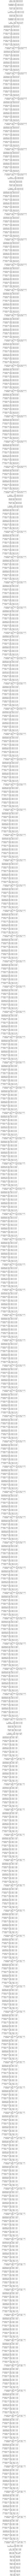

In [29]:
plot_model(
    model1,
    to_file="model1.png",
    show_shapes=True,
    #show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [30]:
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//test_data.batch_size
#n_epochs = 100


from collections import Counter
counter = Counter(train_data.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

from livelossplot import PlotLossesKeras

checkpoint = ModelCheckpoint("../working/DenseNet201Full.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=True)

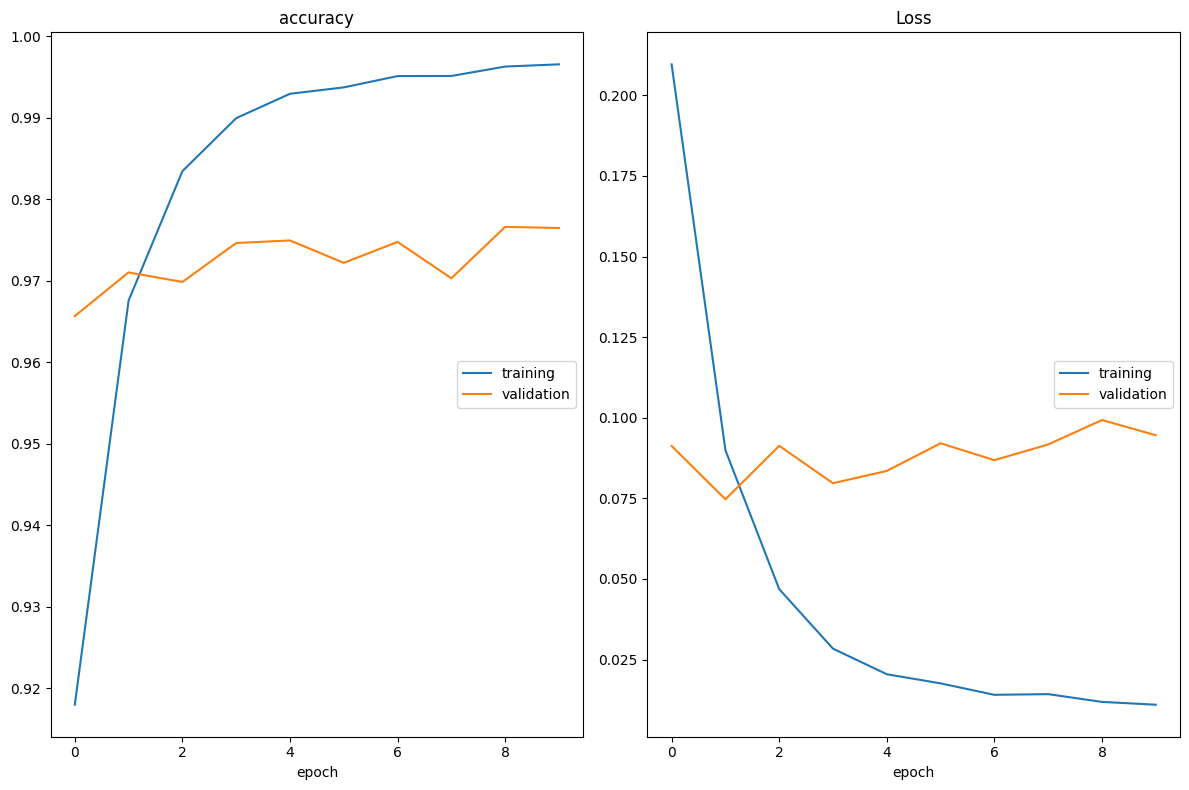

accuracy
	training         	 (min:    0.918, max:    0.997, cur:    0.997)
	validation       	 (min:    0.966, max:    0.977, cur:    0.976)
Loss
	training         	 (min:    0.011, max:    0.210, cur:    0.011)
	validation       	 (min:    0.075, max:    0.099, cur:    0.095)
4862/4862 [==============================] - 1842s 379ms/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.0946 - val_accuracy: 0.9765


In [31]:
history = model1.fit(train_data,
                    epochs =10,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    class_weight = class_weights,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks=[checkpoint, early_stop, PlotLossesKeras()]
                    )

In [32]:
model_preds_1 = model1.predict(test_data,test_data.samples//test_data.batch_size+1)
model_pred_classes_1 = np.argmax(model_preds_1 , axis=1)


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc1 = accuracy_score(true_classes, model_pred_classes_1)
print("DenseNet201-based Model Accuracy: {:.2f}%".format(acc1 * 100))

print('Precision1: %.3f' % precision_score(true_classes, model_pred_classes_1,average='macro'))
print('Recall1: %.3f' % recall_score(true_classes, model_pred_classes_1,average='macro'))
print('F1 Score1: %.3f' % f1_score(true_classes, model_pred_classes_1,average='macro'))



1250/1250 [==============================] - 127s 99ms/step
DenseNet201-based Model Accuracy: 97.68%
Precision1: 0.977
Recall1: 0.977
F1 Score1: 0.977


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

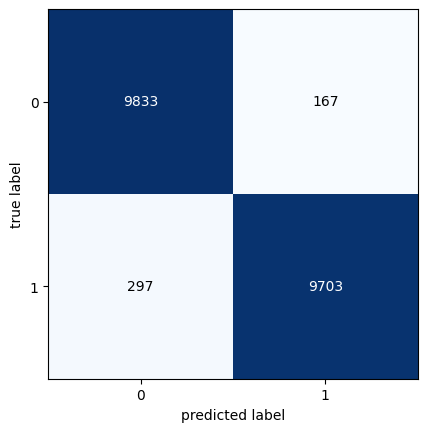

In [33]:
from mlxtend.plotting import plot_confusion_matrix
y = confusion_matrix(test_data.classes, model_pred_classes_1)
plot_confusion_matrix(y)

In [34]:
print('Classification Report')
target_names = ['REAL','FAKE']
print(classification_report(test_data.classes, model_pred_classes_1))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10000
           1       0.98      0.97      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



In [35]:
# Get the names of the ten classes
class_names_1 = test_data.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Greens, #Blues, YlGnBu, YlOrRd
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

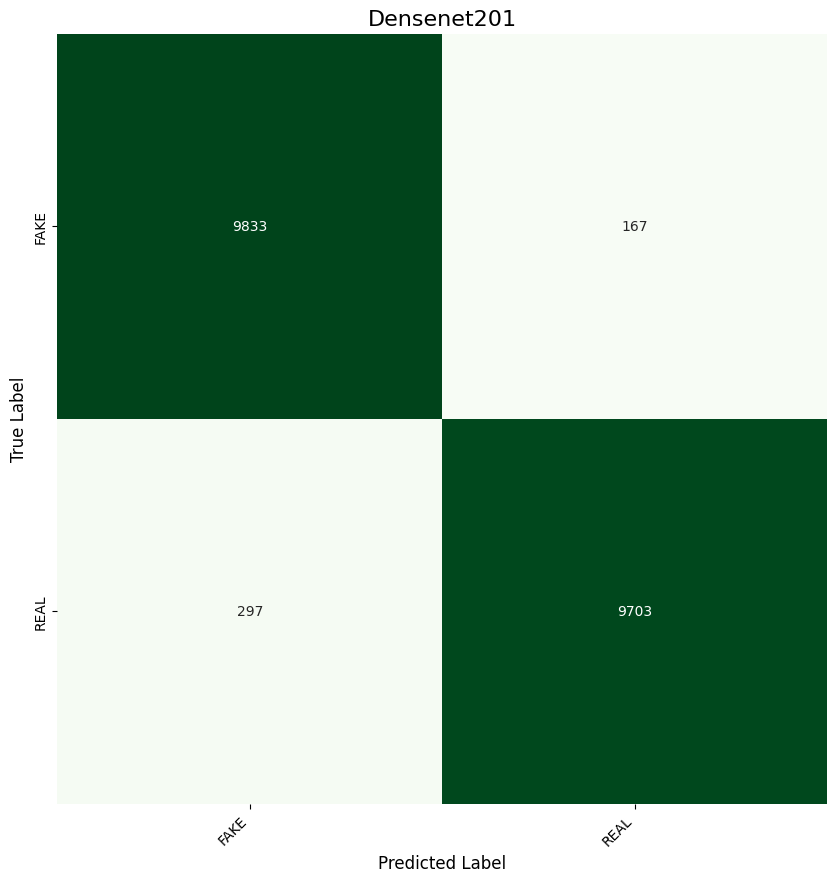

In [36]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))
plot_heatmap(true_classes, model_pred_classes_1, class_names_1, ax1, title="Densenet201")    